# Set up environment variables, constants, and imports

In [1]:
# NOTE - Set the following environment variables to the correct paths for your system if they aren't already set.
import os
os.environ.setdefault('RESULTS_FOLDER', '/mnt/Bunker/nnUNet_Bunker/nnUNet_models')
os.environ.setdefault('nnUNet_preprocessed', '/mnt/Bunker/nnUNet_Bunker/nnUNet_preprocessed')
os.environ.setdefault('nnUNet_raw_data_base', '/mnt/Bunker/nnUNet_Bunker/nnUNet_raw')

'/mnt/Bunker/nnUNet_Bunker/nnUNet_raw'

In [9]:
import functools

import numpy as np
import SimpleITK as sitk  # Extra for handling nifti files in this example
import torch
import matplotlib.pyplot as plt

import attribution_quality as attq
from attribution_quality.nnunet_utils import get_sample_path, get_trainer, OutputMuffle, prep_data
from attribution_quality.splitnet.split_nnunet import decompose_nnunet


import nnunet
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import glob
import tqdm.auto as tqdm
from attribution_quality.utils import resize_cam_image, quick_pred
from attribution_quality.nnunet_utils import get_trainer, prep_data, get_sample_path, prepare_layer_names
from attribution_quality.metrics import compute_quality_score, compute_cam_localization, compute_masked_metrics, compute_masked_metrics_from_source, compare_entropy
from attribution_quality.utils import apply_mask

SAMPLE_SLICE = (82, slice(None), slice(None))  # slice to use 
TASK_ID = 902
FOLD_NUM = 0
SAMPLE_ID = 'nodule_199'
SKIP_TRANSPOSE = False
SAVE_DIR = './samples'
SAMPLE_SAVE_DIR = os.path.join(SAVE_DIR, f'explanation_{attq.KWC.name}', SAMPLE_ID)
os.makedirs(SAMPLE_SAVE_DIR, exist_ok=True)
SAVE_LAYER_CAMS = True  # If False, the layer-wise CAMs will not be saved. Only the final, combined CAM.
SAVE_COMPRESSED = True
SKIP_EXISTING = False  # If layer-wise CAMs have been saved, skip re-generating them


In [10]:
def load_meta(image_path):
    ref_image = sitk.ImageFileReader()
    ref_image.SetFileName(image_path)
    ref_image.ReadImageInformation()
    return ref_image

        
def copy_information(image, ref_image, origin=None, direction=None, spacing=None):
    if isinstance(ref_image, str):
        ref_path = ref_image
        ref_image = load_meta(ref_path)
    assert image.GetSize() == ref_image.GetSize(), 'Image size mismatch'
    new_origin = ref_image.GetOrigin() if origin is None else origin
    image.SetOrigin(new_origin)
    new_direction = ref_image.GetDirection() if direction is None else direction
    image.SetDirection(new_direction)
    new_spacing = ref_image.GetSpacing() if spacing is None else spacing
    image.SetSpacing(new_spacing)

# Load Data and Models

In [11]:
with OutputMuffle('stdout') as f:  # nnunet can be very verbose when loading/preprocessing data and models
    trainer = get_trainer(task=TASK_ID)
    model = trainer.network
    data, slicer = prep_data(trainer, SAMPLE_ID)
    if data.ndim != 5:
        # add batch dimension, channel should already be present
        data = np.expand_dims(data, [i for i in range(5 - data.ndim)])
        
image_path, label_path = get_sample_path(TASK_ID, SAMPLE_ID)
image_path = image_path[0]
image_meta = load_meta(image_path)
label_path = label_path[0]

layer_names, target_layers = prepare_layer_names(trainer, return_targets=True, skip_transpose=SKIP_TRANSPOSE)

# Generate CAMs

In [ ]:
cam_kwargs = {
    'use_cuda': True,
    'n_spatial_dim': 3,
    'batch_size': 4,
    'verbose': 2,
    'allow_amp': True,
    'resize_to_input': False,  # False so that smaller images are saved if `SAVE_LAYER_CAMS` is True
    'activation_func': functools.partial(torch.nn.functional.softmax, dim=1)
}
cam_model = attq.KWC(model, None, **cam_kwargs)  # 
result_cam = None
for target_layer, layer_name in zip(target_layers, layer_names):
    layer_dst = os.path.join(SAMPLE_SAVE_DIR, f'{layer_name}_{cam_model.abbr}.nii')
    if SAVE_COMPRESSED:
        layer_dst += '.gz'
    if SKIP_EXISTING and os.path.exists(layer_dst):
        layer_cam = sitk.ReadImage(layer_dst)
        layer_cam = sitk.GetArrayFromImage(layer_cam)
    else:
        cam_model.change_target_layers(target_layer)
        layer_cam = np.squeeze(cam_model.forward(data)[0])
        if SAVE_LAYER_CAMS:
            layer_cam_image = sitk.GetImageFromArray(layer_cam)
            #NOTE: In this example, CAM images are saved assuming unit spacing. True physical spacing is only used for the combined CAM.
            layer_spacing = (np.asarray(data.shape[2:]) / np.asarray(layer_cam.shape))[::-1]
            layer_cam_image.SetSpacing(layer_spacing)
            sitk.WriteImage(layer_cam_image, layer_dst)
    layer_cam = resize_cam_image(layer_cam, target_size=data.shape[2:], rescale=cam_model.abbr != attq.KWC.abbr)
    layer_cam = np.squeeze(layer_cam)
    result_cam = layer_cam if result_cam is None else result_cam + layer_cam
cam_model.release()

max_mag = max(abs(result_cam.min()), abs(result_cam.max()))
if max_mag > 1e-8:
    result_cam /= max_mag
result_cam = result_cam[tuple(slicer[1:])]  # In case padding was used during `prep_data`. It doesn't happen in this example, but may in other uses.
    
cam_dst = os.path.join(SAMPLE_SAVE_DIR, 'cam_{cam_model.abbr}.nii')
if SAVE_COMPRESSED:
    cam_dst += '.gz'
result_cam_image = sitk.GetImageFromArray(np.squeeze(result_cam))
copy_information(result_cam_image, image_meta)
sitk.WriteImage(result_cam_image, cam_dst)

# Evaluate CAMs

Attribution Quality: 1.2977


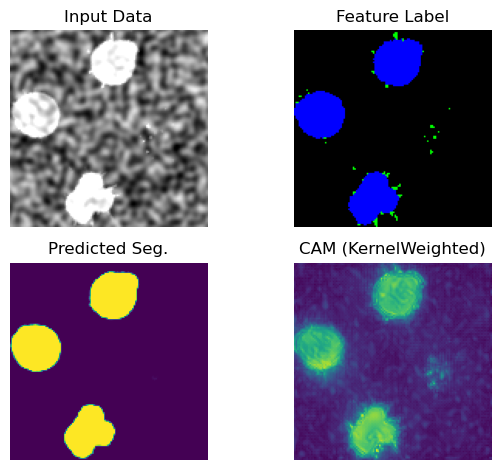

In [18]:
%matplotlib inline
feat_label = sitk.ReadImage(label_path.replace('labelsTs', 'labelsTs_full'))
feat_label = sitk.GetArrayFromImage(feat_label)
feat_label_slice = feat_label[SAMPLE_SLICE]

att_quality, _ = compute_quality_score(model, data, result_cam, feat_label)
print(f'Attribution Quality: {att_quality:.4f}')

baseline_pred = quick_pred(model, data)
cam_slice = result_cam[SAMPLE_SLICE]
feat_label_slice_color = np.zeros(list(feat_label_slice.shape) + [3], dtype=np.uint8)
feat_label_slice_color[feat_label_slice == 1] = [255, 0, 0]  # Red = False Positive Background ("normal" nodules)
feat_label_slice_color[feat_label_slice == 2] = [0, 255, 0]  # Blue = True Positive Foreground (spiculated nodules)
feat_label_slice_color[feat_label_slice == 3] = [0, 0, 255]  # Green = Discriminating Background (nodule spiculations)

fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.ravel():
    ax.axis('off')

axes[0, 0].imshow(np.squeeze(data)[SAMPLE_SLICE], cmap='gray')
axes[0, 0].set_title('Input Data')

axes[0, 1].imshow(feat_label_slice_color)
axes[0, 1].set_title('Feature Label')

axes[1, 0].imshow(np.squeeze(baseline_pred)[SAMPLE_SLICE], cmap='viridis')
axes[1, 0].set_title('Predicted Seg.')

axes[1, 1].imshow(cam_slice, cmap='viridis')
axes[1, 1].set_title(f'CAM ({cam_model.name})')

plt.tight_layout()
plt.show()